# Config

In [1]:
import os
import pandas as pd
import geopandas as gpd 


# Get data

In [9]:
#Read data
datasets = ["IMPD_bus","IMPD_metro","IMPD_slope","IMPD_unevenness"]
dfs = [gpd.read_file(f"../data/{dataset}.geojson") for dataset in datasets]
df = pd.concat(dfs, ignore_index=True)  # remove .values()

print(df.shape)
print(df.columns)
df.head()

(43857, 21)
Index(['CODI_PARADA', 'NOM_PARADA', 'MARQUESINA', 'PAL', 'PAL SOLAR', 'PIU',
       'GEOMETRY', 'Type', 'Evaluation', 'geometry', 'CODI_ACCÉS', 'NOM_ACCÉS',
       'NOM_ESTACIÓ', 'Ascensor', 'Escales', 'Peu Pla', 'Gis_ID', 'Value',
       'Description', 'lat', 'lon'],
      dtype='object')


,CODI_PARADA,NOM_PARADA,MARQUESINA,PAL,PAL SOLAR,PIU,GEOMETRY,Type,Evaluation,geometry,...,NOM_ACCÉS,NOM_ESTACIÓ,Ascensor,Escales,Peu Pla,Gis_ID,Value,Description,lat,lon
0,2.0,Av Icària - Àlaba,1.0,NaN,NaN,1.0,POINT (2.1989850510752147 41.39310425052752),Bus Stop,Accessible,POINT (2.19899 41.3931),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,València - Muntaner,1.0,NaN,NaN,1.0,POINT (2.157891256250179 41.38854563338069),Bus Stop,Accessible,POINT (2.15789 41.38855),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,Mallorca - Balmes,1.0,NaN,NaN,1.0,POINT (2.1587318610871247 41.391021357114504),Bus Stop,Accessible,POINT (2.15873 41.39102),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7.0,Pl Universitat,1.0,NaN,NaN,1.0,POINT (2.163309821110431 41.38590662761268),Bus Stop,Accessible,POINT (2.16331 41.38591),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8.0,Pl de Carles Buïgas,1.0,NaN,NaN,NaN,POINT (2.1501182497304105 41.371045269524885),Bus Stop,Accessible,POINT (2.15012 41.37105),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
barris = gpd.read_parquet("../data/barris.parquet")
print(barris.shape)
print(barris.columns)

(73, 3)
Index(['BARRI', 'NOM', 'geometry'], dtype='object')


# Process data

In [11]:
#Keep relevant columns
relevant_columns = ['Type', 'Value', 'Evaluation', 'Description','geometry']
results = df[relevant_columns]
results.head()

,Type,Value,Evaluation,Description,geometry
0,Bus Stop,NaN,Accessible,NaN,POINT (2.19899 41.3931)
1,Bus Stop,NaN,Accessible,NaN,POINT (2.15789 41.38855)
2,Bus Stop,NaN,Accessible,NaN,POINT (2.15873 41.39102)
3,Bus Stop,NaN,Accessible,NaN,POINT (2.16331 41.38591)
4,Bus Stop,NaN,Accessible,NaN,POINT (2.15012 41.37105)


In [13]:
mapping = {
    "Accessible": 1,
    "Partially accessible": 0.5,
    "Accessible Transversally": 0.5,
    "Accessible Longitudinally": 0.5,
    "Non accessible": 0,}
results.loc[:, "Score"] = results["Evaluation"].map(mapping)
results["Score"].describe()

count    43857.000000
mean         0.730191
std          0.408375
min          0.000000
25%          0.500000
50%          1.000000
75%          1.000000
max          1.000000
Name: Score, dtype: float64

## Aggregate by Neightbourhoods

In [26]:
#Match CRS
barris = barris.to_crs(results.crs)

# Spatial join + aggregation + pivot in one flow
barris_agg = (
    gpd.sjoin(barris, results, how="inner", predicate="intersects")
    .groupby(["BARRI", "NOM", "Type"])
    .agg(Mean_Score=("Score", "mean"), Count=("Score", "count"))
    .reset_index()
    .pivot_table(
        index=["BARRI", "NOM"],
        columns="Type",
        values=["Mean_Score", "Count"],
        fill_value=0
    )
)

# Flatten MultiIndex and reset index
barris_agg.columns = [f"{stat}_{typ}" for stat, typ in barris_agg.columns]
barris_agg = barris_agg.reset_index()

# Compute totals and ponderated mean score
count_cols = [c for c in barris_agg if c.startswith("Count_")]
mean_cols = [c for c in barris_agg if c.startswith("Mean_Score_")]

barris_agg["Total_Count"] = barris_agg[count_cols].sum(axis=1)
barris_agg["Ponderated_Mean_Score"] = (
    (barris_agg[mean_cols].values * barris_agg[count_cols].values).sum(axis=1)
    / barris_agg["Total_Count"]
)
print(barris_agg.shape)
barris_agg.head()

# Add geometry back to the aggregated DataFrame
barris_agg = barris_agg.merge(barris[["BARRI", "geometry"]], on="BARRI", how="left")
barris_agg = gpd.GeoDataFrame(barris_agg, geometry="geometry", crs=barris.crs)
barris_agg.head()

# Make the Ponderated_Mean_Score nicer
barris_agg["Ponderated_Mean_Score"] = barris_agg["Ponderated_Mean_Score"].round(2)*100


(73, 12)


In [30]:
barris_agg.columns
barris_agg.rename(columns={"BARRI":"Number","NOM":"Name","Ponderated_Mean_Score": "Accessibility Score"}, inplace=True)

# Visualize data

<Axes: >

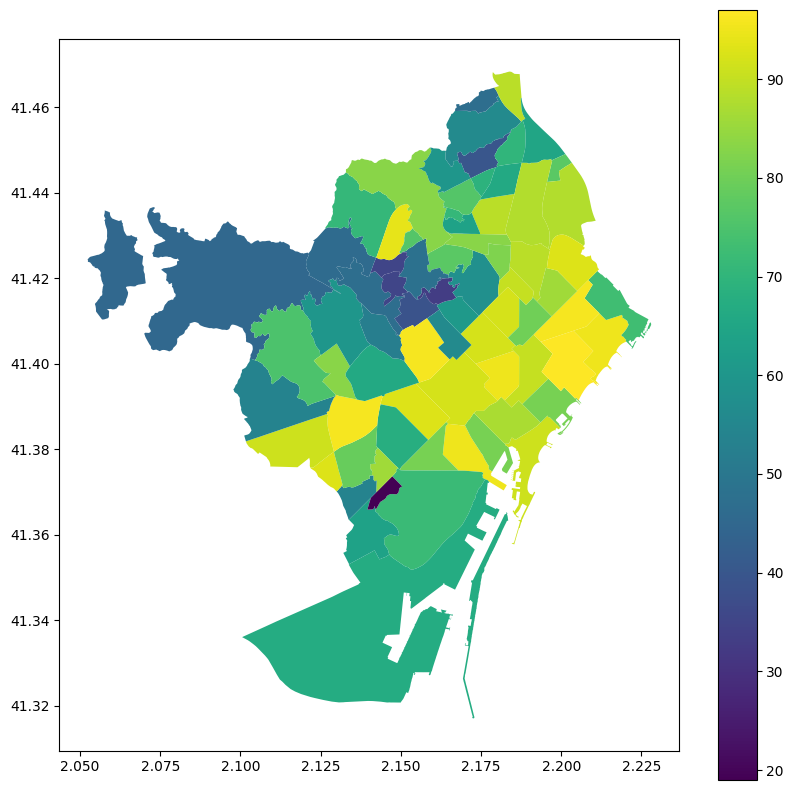

In [31]:
barris_agg.to_crs(epsg=4326, inplace=True)  # Convert to WGS84 for GeoJSON compatibility

barris_agg.plot(
    column='Accessibility Score',
    legend=True,
    figsize=(10, 10),
    markersize=5,
    cmap='viridis'
)

# Save data


In [32]:
barris_agg.to_crs(epsg=4326, inplace=True)  # Convert to WGS84 for GeoJSON compatibility
barris_agg.to_file(
    f"../data/IMPD_barris.geojson", driver='GeoJSON', index=False)